In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

from google.colab import drive
import zipfile


drive.mount('/content/drive/')
zip_path = '/content/drive/MyDrive/img_cap/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

Mounted at /content/drive/


In [ ]:
image_path = '../content/data/Images'

data = pd.read_csv("../content/data/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    # load_img(path, color_mode='rgb', target_size=(img_size, img_size)):
    #   Hàm này từ thư viện keras.preprocessing.image được sử dụng để tải hình ảnh từ đường dẫn đã cho. Tham số color_mode='rgb'
    #   chỉ định rằng hình ảnh sẽ được chuyển đổi thành một ảnh màu RGB. Tham số target_size=(img_size, img_size) xác định kích thước mà hình ảnh sẽ được chuyển đổi thành.
    #   Trong trường hợp này, hình ảnh sẽ được chuyển đổi thành hình vuông có kích thước img_size x img_size.

    img = img_to_array(img)
    # img_to_array(img): Hàm này từ keras.preprocessing.image được sử dụng để chuyển đổi hình ảnh thành một mảng numpy.

    img = img/255.
    # img/255.: Dòng này chia mỗi giá trị trong mảng hình ảnh cho 255 để chuẩn hóa giá trị pixel về khoảng từ 0 đến 1. Điều này làm giảm phức tạp của mô hình và giúp tăng tốc độ huấn luyện.

    return img # Cuối cùng, hàm trả về hình ảnh dưới dạng một mảng numpy đã được chuẩn hóa.




# Hàm này sẽ hiển thị một lưới ảnh có 5 hàng và 5 cột, mỗi hàng chứa 5 ảnh và mỗi ảnh sẽ có tiêu đề là mô tả từ cột "caption" của DataFrame temp_df.
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)  #đặt lại chỉ mục của DataFrame temp_df để bắt đầu từ 0 và loại bỏ chỉ mục cũ.
    plt.figure(figsize = (20 , 20)) #Tạo một hình vẽ với kích thước 20x20 inch.
    n = 0   # Khởi tạo biến n với giá trị 0, sẽ được sử dụng để điều chỉnh vị trí của subplot.
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n) # Tạo một subplot trong lưới 5x5, sử dụng giá trị n để chỉ định vị trí của subplot.
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/data/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off") # Tắt trục của subplot để loại bỏ các chỉ số trên trục x và y.




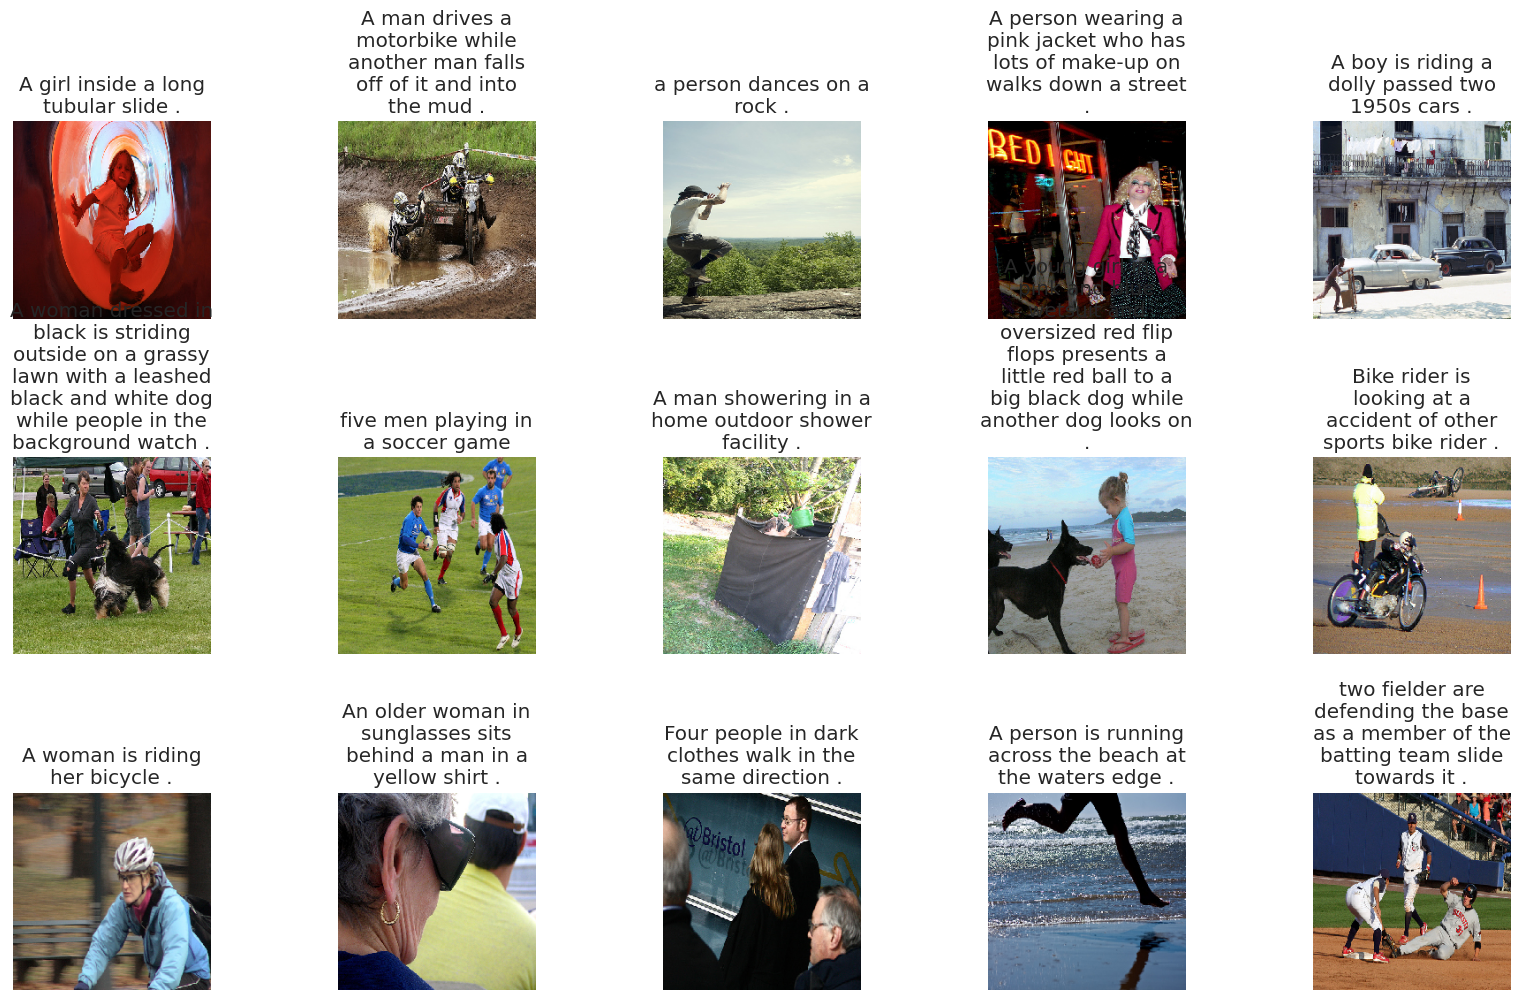

In [ ]:
display_images(data.sample(15))

In [ ]:
def text_preprocessing(data):
  #Chuyển đổi tất cả các ký tự trong cột 'caption' của DataFrame 'data' thành chữ thường.
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    #Loại bỏ tất cả các ký tự không phải là chữ cái từ cột 'caption'
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    #Thay thế mọi chuỗi ký tự trắng liên tiếp bằng một ký tự trắng duy nhất
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    #Chia mỗi câu thành các từ riêng lẻ, loại bỏ các từ có độ dài ít hơn hoặc bằng 1, sau đó nối các từ lại thành một chuỗi mới. Điều này giúp loại bỏ các từ ngắn không cần thiết và tăng tính chính xác của dữ liệu.
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    #Thêm startseq và endseq vào đầu và cuối câu
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data


In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
#Sử dụng Tokenizer để chuyển đổi các câu chú thích thành các chuỗi số nguyên, mỗi số nguyên đại diện cho một từ trong từ điển.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
# Tính toán số lượng từ vựng và độ dài tối đa của câu: Tính toán số lượng từ vựng bằng cách đếm số lượng từ trong từ điển của Tokenizer,
# cộng thêm một cho trường hợp các từ từ 1 đến vocab_size. Độ dài tối đa của câu được tính bằng cách lấy độ dài lớn nhất của các câu chú thích.
images = data['image'].unique().tolist()
nimages = len(images)
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra: Phân chia danh sách các hình ảnh thành tập huấn luyện và tập kiểm tra dựa trên tỷ lệ 85-15.
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]
# Sau đó, tạo ra hai DataFrame train và test tương ứng với tập huấn luyện và tập kiểm tra.
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]


[1, 18, 315, 63, 195, 116, 2]

In [ ]:
model = DenseNet201() #chọn mô hình DenseNet201

# Tạo một mô hình trích xuất đặc trưng (Feature Extractor),
# tạo một mô hình con (fe) từ mô hình DenseNet201 bằng cách chỉ định đầu vào và đầu ra.
# đầu vào là đầu vào của mô hình DenseNet201 và đầu ra là lớp trước lớp cuối cùng, thường là lớp fully connected trước lớp dự đoán.
fe = Model(inputs=model.input, outputs=model.layers[-2].output)


# Trích xuất đặc trưng từ ảnh
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))   # Tải ảnh từ đường dẫn và thay đổi kích thước của nó thành kích thước mong muốn.
    img = img_to_array(img)
    img = img/255.   # Chuyển đổi ảnh thành mảng numpy và chuẩn hóa giá trị pixel về khoảng từ 0 đến 1.
    img = np.expand_dims(img,axis=0)  # Mở rộng chiều của mảng ảnh để phù hợp với đầu vào của mạng nơ-ron sâu.
    feature = fe.predict(img, verbose=0)  # Sử dụng mô hình trích xuất đặc trưng (fe) để dự đoán đặc trưng của ảnh.
    features[image] = feature   # Lưu trữ đặc trưng của mỗi ảnh trong một từ điển features, với khóa là tên của ảnh.




82524592/82524592 [==============================] - 1s 0us/step


  4%|▍         | 305/8091 [00:45<11:51, 10.95it/s]

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

In [ ]:
display_images(samples)
